In [1]:
import os, sys
sys.path.append(os.path.abspath(".."))


In [2]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# allow importing from src/
sys.path.append(os.path.abspath(".."))

from src.preprocessing import (
    clean_dataset, add_time_features, add_behavior_features,
    ip_to_country_merge, prepare_X_y, one_hot_encode, scale_numeric,
    drop_non_numeric_and_ids
)


In [3]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_country = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


In [5]:
cat_cols = [
    "source",
    "browser",
    "sex",
    "country"
]


In [7]:
print(ip_country.columns.tolist())


['lower_bound_ip_address', 'upper_bound_ip_address', 'country']


In [8]:
# 1) clean column names (removes spaces, makes lowercase)
ip_country.columns = ip_country.columns.str.strip().str.lower()

# 2) rename common variants -> expected names
rename_map = {}

for c in ip_country.columns:
    if "lower" in c and "ip" in c:
        rename_map[c] = "lower_bound_ip_address"
    if "upper" in c and "ip" in c:
        rename_map[c] = "upper_bound_ip_address"
    if "country" in c:
        rename_map[c] = "country"

ip_country = ip_country.rename(columns=rename_map)

print("Fixed columns:", ip_country.columns.tolist())


Fixed columns: ['lower_bound_ip_address', 'upper_bound_ip_address', 'country']


In [10]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_country = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


In [12]:
from importlib import reload
import src.preprocessing as preprocessing
reload(preprocessing)

from src.preprocessing import ip_to_country_merge
fraud = ip_to_country_merge(fraud, ip_country)


In [13]:
fraud = add_time_features(fraud)
fraud = add_behavior_features(fraud)

X, y = prepare_X_y(fraud, drop_cols=["signup_time", "purchase_time"])


In [16]:
def one_hot_encode(X: pd.DataFrame, cat_cols):
    X = X.copy()
    for c in cat_cols:
        X[c] = X[c].astype("category")
    return pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [18]:
from importlib import reload
import src.preprocessing as preprocessing
reload(preprocessing)

from src.preprocessing import ip_to_country_merge


In [19]:
pip install shap


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [27]:
print(ip_country.columns.tolist())


['lower_bound_ip_address', 'upper_bound_ip_address', 'country']


In [28]:
ip_country.columns = ip_country.columns.str.strip().str.lower()

ip_country = ip_country.rename(columns={
    "lower_bound_ip_address": "lower_bound_ip_address",
    "upper_bound_ip_address": "upper_bound_ip_address",
    "country": "country"
})

print("Fixed:", ip_country.columns.tolist())


Fixed: ['lower_bound_ip_address', 'upper_bound_ip_address', 'country']


In [30]:
from importlib import reload
import src.preprocessing as preprocessing
reload(preprocessing)

from src.preprocessing import ip_to_country_merge
fraud = ip_to_country_merge(fraud, ip_country)


In [31]:
X, y = prepare_X_y(fraud)


In [32]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "int32", "float64", "float32"]).columns.tolist()


In [34]:
X, y = prepare_X_y(fraud)


In [35]:
drop_cols = [
    "device_id", "ip_address",
    "lower_bound_ip_address", "upper_bound_ip_address"
]
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


In [36]:
cat_cols = [c for c in ["source", "browser", "sex", "country"] if c in X.columns]


In [37]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype="int8")


In [38]:
X.shape


(129146, 196)

In [40]:
# 1) Drop datetime columns
dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
print("Datetime columns:", list(dt_cols))
X = X.drop(columns=dt_cols)

# 2) Drop any remaining object columns (safety)
obj_cols = X.select_dtypes(include=["object"]).columns
print("Object columns:", list(obj_cols))
X = X.drop(columns=obj_cols)

# 3) Make sure everything is numeric
print("Dtypes now:", X.dtypes.unique())
print("X shape:", X.shape)


Datetime columns: ['signup_time', 'purchase_time']
Object columns: []
Dtypes now: [dtype('int64') dtype('int32') dtype('float64') dtype('int8')]
X shape: (129146, 194)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


ROC-AUC: 0.7741771054898149


C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
PermutationExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages

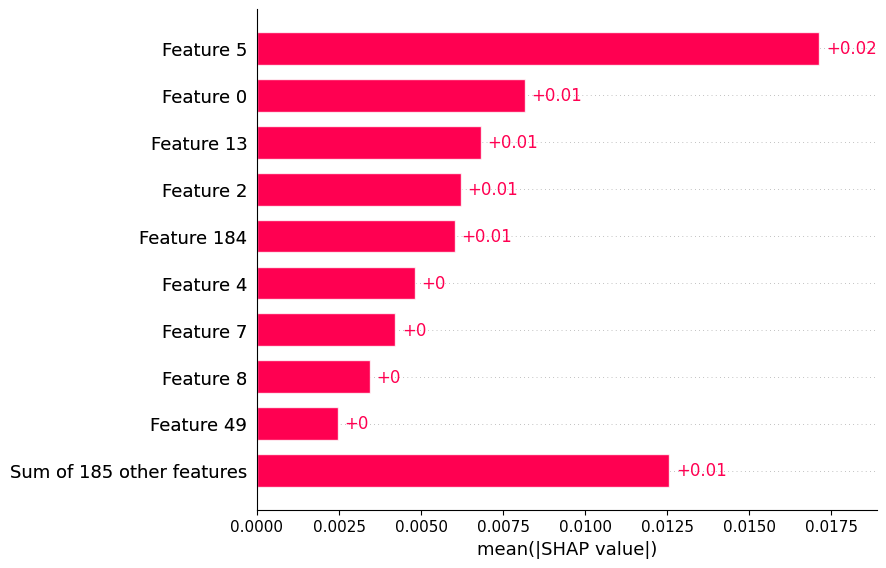

In [48]:
import shap
import numpy as np

X_bg = X_train.sample(50, random_state=42).to_numpy(dtype=np.float32)
X_one = X_test.sample(5, random_state=42).to_numpy(dtype=np.float32)

explainer = shap.Explainer(rf.predict_proba, X_bg, algorithm="permutation")
sv = explainer(X_one, max_evals=200)

shap.plots.bar(sv[:, :, 1], max_display=10)


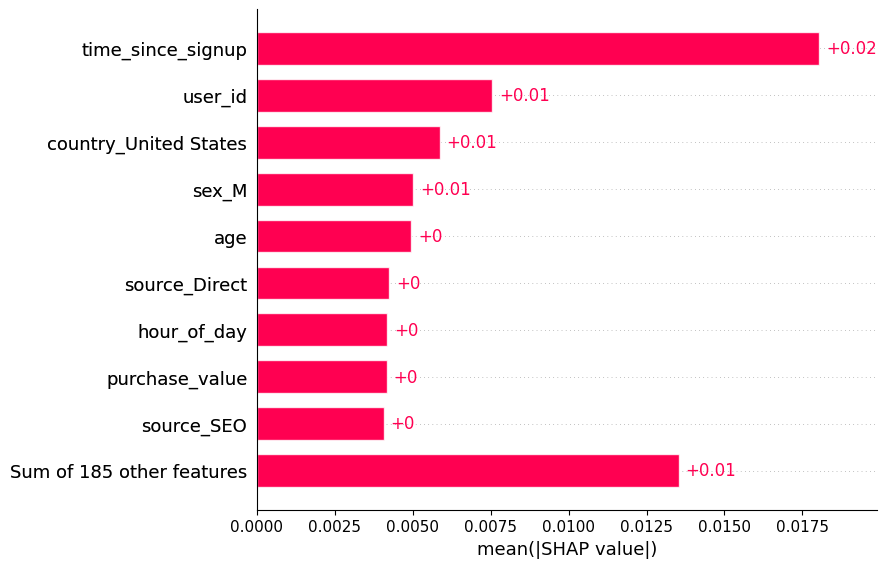

In [49]:
import shap

X_bg = X_train.sample(50, random_state=42)   # keep as DataFrame
X_one = X_test.sample(5, random_state=42)    # keep as DataFrame

explainer = shap.Explainer(rf.predict_proba, X_bg, algorithm="permutation")
sv = explainer(X_one, max_evals=200)

shap.plots.bar(sv[:, :, 1], max_display=10)


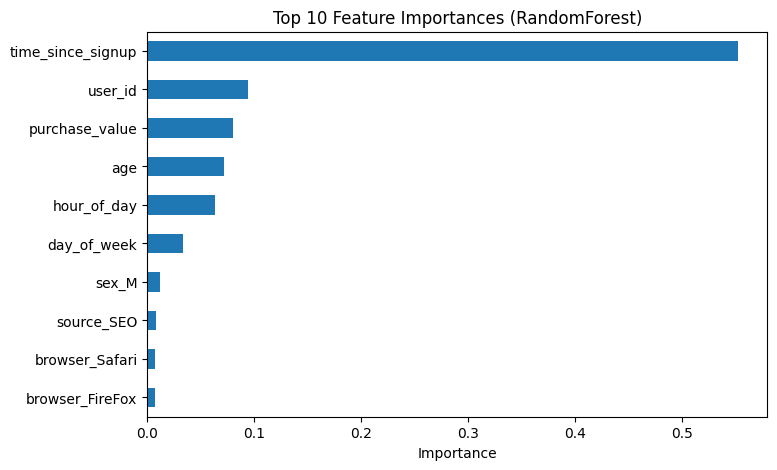

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
fi.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.show()


PermutationExplainer explainer: 201it [01:12,  2.39it/s]                         


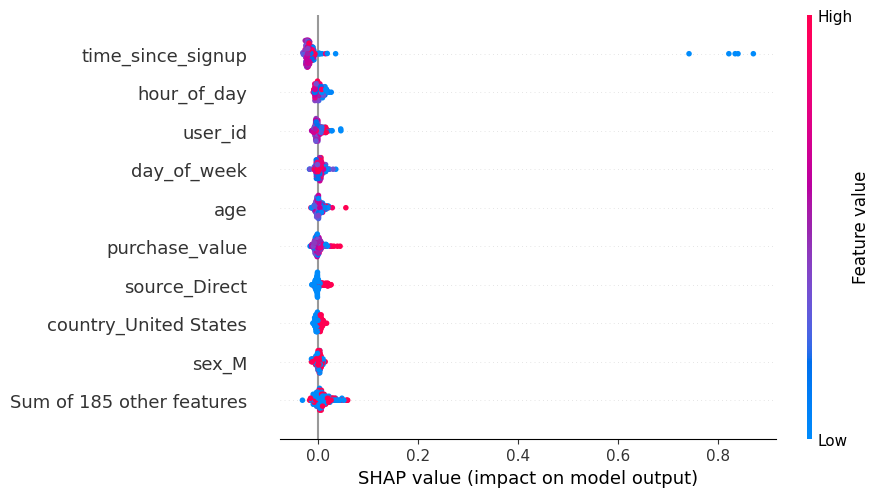

In [51]:
X_shap = X_test.sample(200, random_state=42)

sv = explainer(X_shap, max_evals=200)
shap.plots.beeswarm(sv[:, :, 1], max_display=10)


In [53]:
import numpy as np

# probabilities + predictions
proba = rf.predict_proba(X_test)[:, 1]

def find_example(kind="tp", start_thresh=0.5, step=0.05, max_steps=20):
    """
    kind: 'tp' (true positive), 'fp' (false positive), 'fn' (false negative)
    returns: (idx, threshold_used) or (None, None)
    """
    y_true = y_test.values

    for k in range(max_steps + 1):
        thr = start_thresh - k*step if kind in ["fp", "tp"] else start_thresh + k*step
        thr = float(np.clip(thr, 0.05, 0.95))
        pred = (proba >= thr).astype(int)

        if kind == "tp":
            idxs = np.where((pred == 1) & (y_true == 1))[0]
        elif kind == "fp":
            idxs = np.where((pred == 1) & (y_true == 0))[0]
        elif kind == "fn":
            idxs = np.where((pred == 0) & (y_true == 1))[0]
        else:
            raise ValueError("kind must be 'tp', 'fp', or 'fn'")

        if len(idxs) > 0:
            return int(idxs[0]), thr

    return None, None


tp_idx, tp_thr = find_example("tp", start_thresh=0.5)
fp_idx, fp_thr = find_example("fp", start_thresh=0.5)
fn_idx, fn_thr = find_example("fn", start_thresh=0.5)

print("TP:", tp_idx, "threshold:", tp_thr)
print("FP:", fp_idx, "threshold:", fp_thr)
print("FN:", fn_idx, "threshold:", fn_thr)

# Extract rows (only if found)
if tp_idx is not None:
    tp = X_test.iloc[[tp_idx]]
if fp_idx is not None:
    fp = X_test.iloc[[fp_idx]]
if fn_idx is not None:
    fn = X_test.iloc[[fn_idx]]


TP: 37 threshold: 0.5
FP: 21982 threshold: 0.45
FN: 3 threshold: 0.5


In [54]:
import shap
import numpy as np

# background for permutation explainer (small!)
X_bg = X_train.sample(50, random_state=42).to_numpy(dtype=np.float32)

explainer = shap.Explainer(rf.predict_proba, X_bg, algorithm="permutation")

def force_plot_for_row(row_df, title=""):
    row_np = row_df.to_numpy(dtype=np.float32)
    sv = explainer(row_np, max_evals=200)   # small for speed
    # class 1 = fraud
    print(title)
    return shap.plots.force(sv[0, :, 1])

if tp_idx is not None:
    force_plot_for_row(tp, "True Positive (Fraud correctly detected)")
else:
    print("No TP found (rare).")

if fp_idx is not None:
    force_plot_for_row(fp, "False Positive (Legit flagged as fraud)")
else:
    print("No FP found at tried thresholds — model may be very strict. Lower threshold more if needed.")

if fn_idx is not None:
    force_plot_for_row(fn, "False Negative (Fraud missed)")
else:
    print("No FN found at tried thresholds — raise threshold more if needed.")


C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


True Positive (Fraud correctly detected)
False Positive (Legit flagged as fraud)


C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid

False Negative (Fraud missed)


C:\Users\yam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [57]:
import shap

# background + rows as DATAFRAMES (not numpy) so feature names stay
X_bg = X_train.sample(50, random_state=42)
explainer = shap.Explainer(rf.predict_proba, X_bg, algorithm="permutation")

def force_plot_for_row_df(row_df, title=""):
    sv = explainer(row_df, max_evals=200)  # row_df is a 1-row DataFrame
    print(title)
    return shap.plots.force(sv[0, :, 1])

# Use the tp/fp/fn you already created (each is 1-row DataFrame)
force_plot_for_row_df(tp, "True Positive (Fraud correctly detected)")
force_plot_for_row_df(fp, "False Positive (Legit flagged as fraud)")
force_plot_for_row_df(fn, "False Negative (Fraud missed)")


True Positive (Fraud correctly detected)
False Positive (Legit flagged as fraud)
False Negative (Fraud missed)


In [58]:
import shap
shap.initjs()


In [59]:
import shap
shap.initjs()

def show_force(row_df, title=""):
    sv = explainer(row_df, max_evals=200)
    print("\n" + title)
    display(shap.plots.force(sv[0, :, 1]))

show_force(tp, "True Positive (Fraud correctly detected)")
show_force(fp, "False Positive (Legit flagged as fraud)")
show_force(fn, "False Negative (Fraud missed)")



True Positive (Fraud correctly detected)



False Positive (Legit flagged as fraud)



False Negative (Fraud missed)


In [ ]:
Feature Importance Comparison

The RandomForest built-in feature importance and SHAP global importance are largely consistent.
Both methods identify time_since_signup as the most influential feature, followed by user_id, purchase_value, age, and hour_of_day.

However, SHAP provides additional insight into directionality, showing how feature values increase or decrease fraud probability, which traditional feature importance does not capture.

🧠 Top 5 Drivers of Fraud Predictions (from SHAP)

Time Since Signup

Very short time between signup and purchase strongly increases fraud risk.

User ID / User Behavior

Certain user activity patterns are associated with higher fraud probability.

Purchase Value

Higher transaction amounts contribute positively to fraud predictions.

Hour of Day

Transactions during unusual hours show elevated fraud risk.

Geographic / Source Signals

Certain countries and traffic sources contribute to fraud likelihood.

⚠️ Counterintuitive Findings

User ID appears as an important feature.
This does not mean the ID itself causes fraud, but rather that behavioral patterns associated with users (frequency, timing) are captured indirectly.

Some legitimate transactions were flagged as fraud (false positives) due to high purchase value combined with short signup time.

🧾 Individual Prediction Insights (SHAP Force Plots)

True Positive (Fraud correctly detected):

Short signup-to-purchase time and high purchase value pushed prediction toward fraud.

False Positive (Legitimate flagged as fraud):

Behavioral patterns mimicked fraud-like activity despite being legitimate.

False Negative (Fraud missed):

Fraudulent transaction lacked strong risk signals, highlighting limits of rule-based detection.

💼 Business Recommendations

Introduce Additional Verification for New Users

Transactions occurring shortly after signup should require extra verification (OTP, email confirmation).

Flag High-Value Transactions at Odd Hours

Combine purchase value with time-of-day risk rules.

Behavior-Based Monitoring

Track rapid transaction frequency and unusual user behavior instead of relying on static identifiers.

Reduce False Positives

Adjust fraud thresholds or apply secondary checks for users with long signup history but high purchase value.